# Pretraining Forecasters on Panel Data

This notebook demonstrates how to **pretrain** sktime forecasters on a collection
of related time series before fine-tuning them on a specific target series.

Pretraining is useful when you have many related series that share common temporal
patterns. The model first learns these shared patterns from the panel, then
adapts to a specific series with fewer observations.

**Prerequisites**
- Basic familiarity with sktime forecasting (see `01_forecasting.ipynb`)
- Understanding of panel/hierarchical data formats (see `01c_forecasting_hierarchical_global.ipynb`)

**Dependencies**
- `sktime` (all examples)
- `rdata`, `requests` (for loading the `aus_retail` dataset via `load_fpp3`)
- `torch` (only for the `LTSFLinearForecaster` section)

In [1]:
# imports used throughout this notebook
import matplotlib.pyplot as plt
import pandas as pd

from sktime.datasets import load_fpp3, load_hierarchical_sales_toydata
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.dummy_global import DummyGlobalForecaster
from sktime.registry import all_estimators
from sktime.utils._testing.hierarchical import _make_hierarchical

## Background

### Pretraining vs. other approaches

sktime supports several ways to leverage multiple time series. The table below
helps decide which approach fits your use case.

| Approach | Use when |
|---|---|
| `fit` only | You have a single series with sufficient history |
| `pretrain` + `fit` | You have related series and want to transfer learned patterns to a target series |
| Foundation model (Chronos, MOIRAI, ...) | You want zero-shot or few-shot forecasting from a large externally trained model |
| Global forecasting | You want a single model that predicts **all** series jointly, without per-series fine-tuning |

The key difference between pretraining and foundation models: foundation models
ship pre-trained on massive external corpora, while the `pretrain` API lets you
train on **your own domain data**.

### Estimator state lifecycle

Every sktime forecaster tracks its lifecycle phase via the `state` property.
Pretraining introduces an intermediate state between construction and fitting:

```
             pretrain()              fit()             predict()
   "new" ──────────────> "pretrained" ──────> "fitted" ──────────> ...
     │                                           ^
     └───────────────── fit() ───────────────────┘
```

- Calling `fit` on a `"new"` forecaster resets and trains from scratch (the standard workflow).
- Calling `fit` on a `"pretrained"` forecaster preserves pretrained weights and fine-tunes.

## Loading panel data

Pretraining requires panel or hierarchical data (multiple time series instances).
We use the hierarchical sales toy dataset: monthly sales for 4 product groups
across 2 product lines, giving us 4 individual series with 60 time points each.

In [2]:
y_panel = load_hierarchical_sales_toydata()

print(f"Shape: {y_panel.shape}")
print(f"Index levels: {y_panel.index.names}")
print(f"Unique series: {len(y_panel.index.droplevel(-1).unique())}")
y_panel.head(10)

Shape: (240, 1)
Index levels: ['Product line', 'Product group', 'Date']
Unique series: 4


Sales
Product line     Product group Date          
Food preparation Hobs          2000-01  245.0
                               2000-02  144.0
                               2000-03  184.0
                               2000-04  265.0
                               2000-05  236.0
                               2000-06   97.0
                               2000-07  190.0
                               2000-08  135.0
                               2000-09  130.0
                               2000-10  172.0

The plot below shows all 4 product series side by side. These are the series the
forecaster will learn shared patterns from during pretraining.

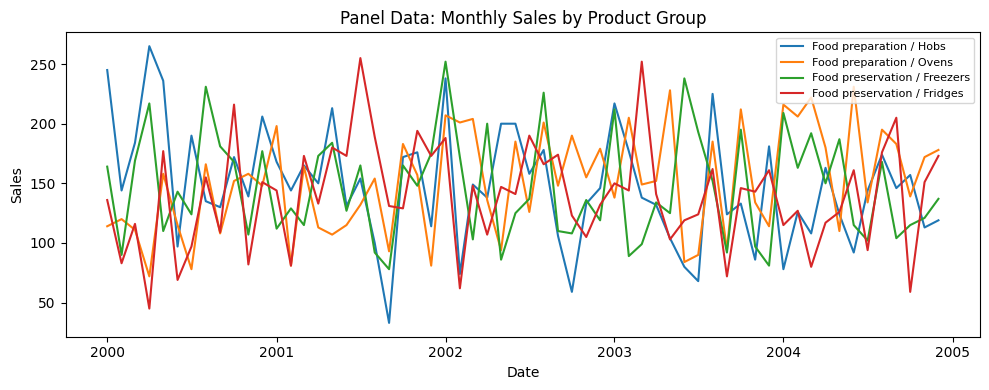

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))

series_ids = y_panel.index.droplevel(-1).unique()
for series_id in series_ids:
    series = y_panel.xs(series_id)["Sales"]
    label = " / ".join(series_id)
    ax.plot(series.index.to_timestamp(), series.values, label=label)

ax.set_title("Panel Data: Monthly Sales by Product Group")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

The four series fluctuate around similar value ranges (roughly 50-250) but
with distinct patterns and levels. This shared scale and temporal structure
is exactly what pretraining can exploit: a forecaster exposed to all four
series during pretraining learns a reasonable baseline for the domain before
ever seeing the specific target series.

We also extract one specific series to use as our fine-tuning target later.

In [4]:
y_target = y_panel.xs(("Food preparation", "Hobs"))["Sales"]
print(f"Target series length: {len(y_target)}")
y_target.tail()

Target series length: 60


Date
2004-08    174.0
2004-09    146.0
2004-10    157.0
2004-11    113.0
2004-12    119.0
Freq: M, Name: Sales, dtype: float64

The target series (Food preparation / Hobs) is highlighted below. This is the
series we will fine-tune on after pretraining.

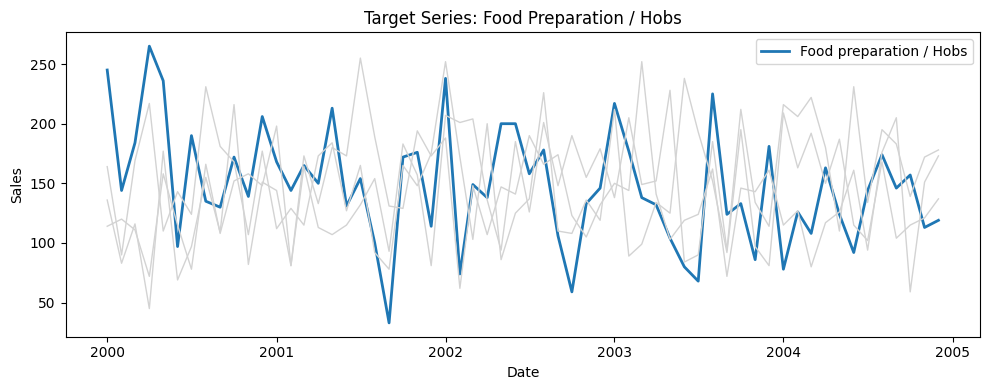

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))

for series_id in series_ids:
    series = y_panel.xs(series_id)["Sales"]
    is_target = series_id == ("Food preparation", "Hobs")
    ax.plot(
        series.index.to_timestamp(),
        series.values,
        color="C0" if is_target else "lightgrey",
        linewidth=2 if is_target else 1,
        label=" / ".join(series_id) if is_target else None,
    )

ax.set_title("Target Series: Food Preparation / Hobs")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
plt.tight_layout()
plt.show()

The highlighted series (Food preparation / Hobs) is the one we will fine-tune on
after pretraining. The grey lines show the other panel members. While all series
share a similar range and monthly frequency, the target series has its own
characteristic fluctuations. The goal of pretraining is to give the forecaster a
head start by learning the common structure from the full panel, then adapting to
these target-specific patterns during `fit`.

## Example 1: DummyGlobalForecaster (no deep learning)

`DummyGlobalForecaster` is a lightweight baseline that computes summary statistics
during pretraining. It requires no deep learning dependencies and is useful for
testing the pretraining API and as a comparison baseline.

The three-step workflow is always the same, regardless of the forecaster:

1. **`pretrain(y_panel)`** on panel data
2. **`fit(y_target)`** on the target series
3. **`predict(fh)`** to get forecasts

### Step 1: Pretrain

The forecaster learns global statistics (mean, std) from all 4 product series.
After this call, the `state` property changes from `"new"` to `"pretrained"`.

In [6]:
forecaster = DummyGlobalForecaster(strategy="mean")

forecaster.pretrain(y_panel)

print(f"State:        {forecaster.state}")
print(f"Global mean:  {forecaster.global_mean_:.2f}")
print(f"Instances:    {forecaster.n_pretrain_instances_}")

State:        pretrained
Global mean:  146.12
Instances:    4


### Step 2: Fit on the target series

Because the forecaster is in the `"pretrained"` state, `fit` preserves the
pretrained statistics and only sets the context (cutoff, last value) for the
target series. The state moves to `"fitted"`.

In [7]:
forecaster.fit(y_target, fh=[1, 2, 3])
print(f"State: {forecaster.state}")

State: fitted


### Step 3: Predict

With the `"mean"` strategy, the forecaster simply repeats the global mean learned
during pretraining for each forecast horizon step.

In [8]:
y_pred = forecaster.predict()
y_pred

2005-01    146.120833
2005-02    146.120833
2005-03    146.120833
Freq: M, Name: Sales, dtype: float64

The following plot shows the target series history together with the 3-step-ahead
forecast produced by the pretrained `DummyGlobalForecaster`.

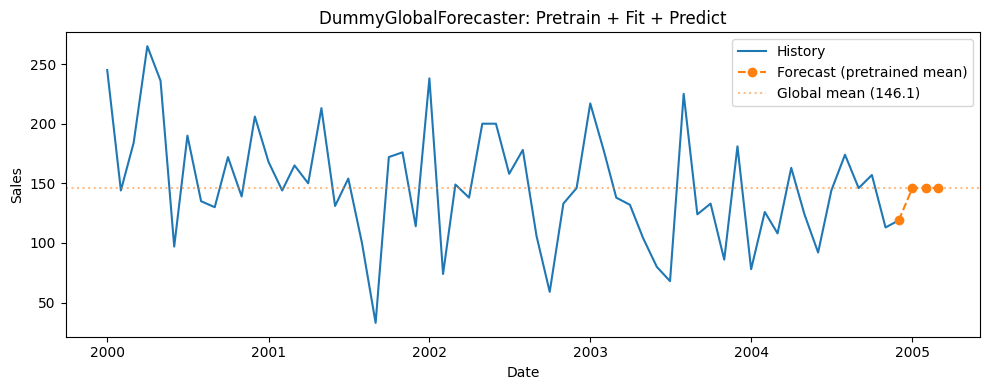

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(y_target.index.to_timestamp(), y_target.values, label="History")

# connect forecast to last history point
last_idx = y_target.index[-1:]
last_val = y_target.iloc[-1]

y_pred_plot = pd.Series(
    [last_val] + y_pred.values.tolist(),
    index=last_idx.append(y_pred.index),
)
ax.plot(
    y_pred_plot.index.to_timestamp(),
    y_pred_plot.values,
    "o--",
    color="C1",
    label="Forecast (pretrained mean)",
)
ax.axhline(
    forecaster.global_mean_,
    color="C1",
    linestyle=":",
    alpha=0.5,
    label=f"Global mean ({forecaster.global_mean_:.1f})",
)
ax.set_title("DummyGlobalForecaster: Pretrain + Fit + Predict")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
plt.tight_layout()
plt.show()

The forecast (orange dashed line) is a flat continuation at the global mean
of ~146, computed across all four panel series during pretraining. The dotted
horizontal line confirms this level. While this is a naive baseline that ignores
trend and seasonality, it demonstrates the full pretrain-fit-predict lifecycle.
The forecast sits near the center of the historical fluctuations, which is
exactly what a global mean strategy should produce.

### Inspecting pretrained vs. fitted parameters

Attributes set during `pretrain` and `fit` are tracked separately. This
separation matters because pretrained attributes survive cloning (see below)
while fitted attributes do not.

In [10]:
print("Pretrained parameters (set by pretrain):")
for key, val in sorted(forecaster.get_pretrained_params().items()):
    print(f"  {key}: {val}")

print("\nFitted parameters (set by fit):")
for key, val in sorted(forecaster.get_fitted_params().items()):
    print(f"  {key}: {val}")

Pretrained parameters (set by pretrain):
  global_mean_: 146.12083333333334
  global_std_: 44.961070931479775
  n_pretrain_instances_: 4
  n_pretrain_timepoints_: 240

Fitted parameters (set by fit):
  global_mean: 146.12083333333334
  global_std: 44.961070931479775
  last_value: 119.0
  n_pretrain_instances: 4
  n_pretrain_timepoints: 240


## Example 2: LTSFLinearForecaster (deep learning)

For neural network forecasters, pretraining trains the network weights on panel
data. The subsequent `fit` call fine-tunes those same weights on the target series
instead of starting from random initialization.

To demonstrate this, we pretrain on the **Australian retail turnover** dataset
(`aus_retail` from the `fpp3` package): 152 monthly retail sales series spanning
1982-2018. This is real-world retail data that shares seasonal patterns and
scale characteristics with our target series, making it a good candidate for
transfer learning.

This section requires `torch`. If it is not installed, skip to the next section.

In [11]:
from sktime.forecasting.ltsf import LTSFLinearForecaster

# load real retail data for pretraining (requires rdata, requests)
y_retail = load_fpp3("aus_retail")[["Turnover"]]
n_retail = len(y_retail.index.droplevel(-1).unique())
print(f"Pretraining panel: {n_retail} series, {y_retail.shape[0]} data points")

nn_forecaster = LTSFLinearForecaster(
    seq_len=24,
    pred_len=6,
    num_epochs=5,
    batch_size=16,
    lr=1e-3,
)

nn_forecaster.pretrain(y_retail)
print(f"State: {nn_forecaster.state}")

# hold out last pred_len observations for evaluation later
y_train = y_target.iloc[: -nn_forecaster.pred_len]
y_test = y_target.iloc[-nn_forecaster.pred_len :]

Pretraining panel: 152 series, 64532 data points
State: pretrained


Fine-tune the pretrained network on the target series and produce forecasts.
The forecasting horizon must not exceed `pred_len` (the network's output
dimension, fixed at construction time).

In [12]:
fh = ForecastingHorizon(list(range(1, nn_forecaster.pred_len + 1)), is_relative=True)

nn_forecaster.fit(y_train, fh=fh)
y_pred_nn = nn_forecaster.predict()

print(f"State: {nn_forecaster.state}")
y_pred_nn

State: fitted


2004-07     95.265869
2004-08    180.962463
2004-09     84.139977
2004-10    112.490295
2004-11     94.758965
2004-12    145.743713
Freq: M, Name: Sales, dtype: float32

### Pretrained vs. fit-only comparison

To see the effect of pretraining, we hold out the last 6 observations of the
target series as ground truth. We train two `LTSFLinearForecaster` models
with the same hyperparameters: one pretrained on the `aus_retail` panel, one
fit from scratch. Both are then fine-tuned (or just fitted) on the same
54-point training portion of the target series.

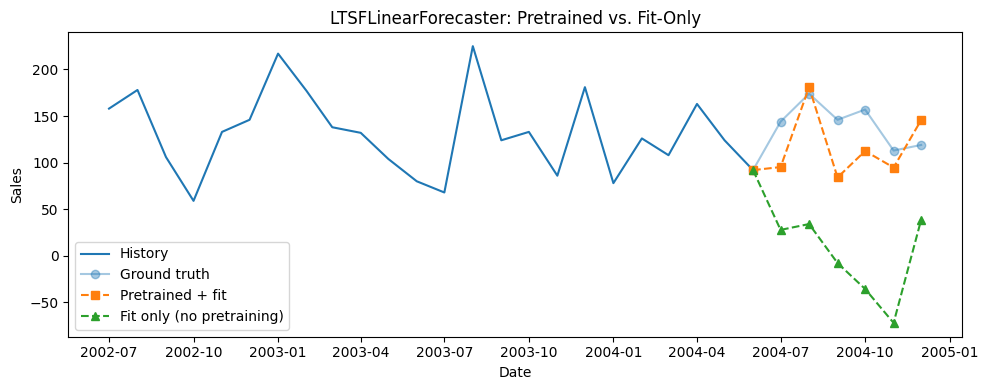

In [13]:
# fit-only baseline (no pretraining, same hyperparameters)
nn_baseline = LTSFLinearForecaster(
    seq_len=24,
    pred_len=6,
    num_epochs=5,
    batch_size=16,
    lr=1e-3,
)
nn_baseline.fit(y_train, fh=fh)
y_pred_baseline = nn_baseline.predict()

fig, ax = plt.subplots(figsize=(10, 4))

# show only the last 24 months of training data for readability
y_recent = y_train.iloc[-24:]
ax.plot(y_recent.index.to_timestamp(), y_recent.values, color="C0", label="History")

# connect forecast lines to the last history point
last_train_idx = y_train.index[-1:]
last_train_val = y_train.iloc[-1]

y_truth_plot = pd.Series(
    [last_train_val] + y_test.values.tolist(),
    index=last_train_idx.append(y_test.index),
)
y_pretrain_plot = pd.Series(
    [last_train_val] + y_pred_nn.values.tolist(),
    index=last_train_idx.append(y_pred_nn.index),
)
y_baseline_plot = pd.Series(
    [last_train_val] + y_pred_baseline.values.tolist(),
    index=last_train_idx.append(y_pred_baseline.index),
)

ax.plot(
    y_truth_plot.index.to_timestamp(),
    y_truth_plot.values,
    "o-",
    color="C0",
    alpha=0.4,
    label="Ground truth",
)
ax.plot(
    y_pretrain_plot.index.to_timestamp(),
    y_pretrain_plot.values,
    "s--",
    color="C1",
    label="Pretrained + fit",
)
ax.plot(
    y_baseline_plot.index.to_timestamp(),
    y_baseline_plot.values,
    "^--",
    color="C2",
    label="Fit only (no pretraining)",
)
ax.set_title("LTSFLinearForecaster: Pretrained vs. Fit-Only")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
plt.tight_layout()
plt.show()

The pretrained model (orange squares) tracks the ground truth (light blue circles)
much more closely than the fit-only baseline (green triangles). The baseline,
trained from random weight initialization on only 54 data points, produces
erratic predictions that often go negative or miss the scale entirely. In
contrast, pretraining on 152 real retail series gives the network a sensible
starting point for weights and biases, so fine-tuning on the small target series
converges to a much better solution. This is the core value proposition of
pretraining: transferring learned structure from a large related corpus to
improve forecasting on a data-scarce target.

## Incremental pretraining

In practice, panel data may arrive in batches. Calling `pretrain` a second time
on an already pretrained forecaster invokes `_pretrain_update` internally,
allowing the implementation to decide how to incorporate new data.

How the update works depends on the forecaster:
- **`DummyGlobalForecaster`** recomputes statistics from the new batch only (replacing, not accumulating).
- **Neural network forecasters** (e.g., `LTSFLinearForecaster`) continue training from the current weights, achieving true incremental learning.

This works from both the `"pretrained"` and `"fitted"` states.

In [14]:
incremental = DummyGlobalForecaster(strategy="mean")

batch_1 = _make_hierarchical(
    hierarchy_levels=(3,),
    min_timepoints=24,
    max_timepoints=24,
    random_state=0,
)
incremental.pretrain(batch_1)
print(
    f"After batch 1: mean={incremental.global_mean_:.4f}, "
    f"instances={incremental.n_pretrain_instances_}"
)

batch_2 = _make_hierarchical(
    hierarchy_levels=(2,),
    min_timepoints=24,
    max_timepoints=24,
    random_state=42,
)
incremental.pretrain(batch_2)
print(
    f"After batch 2: mean={incremental.global_mean_:.4f}, "
    f"instances={incremental.n_pretrain_instances_}"
)

After batch 1: mean=3.5480, instances=3
After batch 2: mean=2.7544, instances=2


## Cloning preserves pretrained state

sktime's `.clone()` method copies pretrained attributes to the clone. This is
critical for cross-validation and hyperparameter tuning, where estimators are
cloned internally so that each fold starts from the same pretrained baseline.

**Important:** `sklearn.base.clone` does **not** preserve pretrained state.
sktime's CV and tuning tools use `.clone()` internally, so this works
transparently when using `ForecastingGridSearchCV` and similar utilities.

In [15]:
original = DummyGlobalForecaster()
original.pretrain(y_panel)

cloned = original.clone()

print(f"Original: state={original.state}, mean={original.global_mean_:.2f}")
print(f"Clone:    state={cloned.state}, mean={cloned.global_mean_:.2f}")

Original: state=pretrained, mean=146.12
Clone:    state=pretrained, mean=146.12


## Discovering pretrainable forecasters

Not every forecaster supports pretraining. Those that do declare the
`capability:pretrain` tag. Use `all_estimators` to list them.

In [16]:
all_estimators(
    "forecaster",
    filter_tags={"capability:pretrain": True},
    as_dataframe=True,
)

/home/me/anaconda3/envs/dev-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-17 17:14:47.639141: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,name,object
0,DummyGlobalForecaster,<class 'sktime.forecasting.dummy_global.DummyG...
1,LTSFLinearForecaster,<class 'sktime.forecasting.ltsf.LTSFLinearFore...
2,LTSFNLinearForecaster,<class 'sktime.forecasting.ltsf.LTSFNLinearFor...


## Summary

Key takeaways from this notebook:

- **`pretrain(y_panel)`** learns shared patterns from panel data and sets state to `"pretrained"`
- **`fit(y_series)`** fine-tunes on a single series, preserving pretrained weights
- **`get_pretrained_params()`** and **`get_fitted_params()`** inspect parameters from each phase separately
- Calling `pretrain` again invokes **`_pretrain_update`**, whose behavior is implementation-specific
- sktime's **`.clone()`** preserves pretrained state, enabling cross-validation on pretrained models
- Use **`all_estimators`** with `filter_tags={"capability:pretrain": True}` to discover pretrainable forecasters

**Next steps**
- [Hierarchical and global forecasting](../01c_forecasting_hierarchical_global.ipynb) for panel data concepts and global models
- [Forecasting with sktime](../01_forecasting.ipynb) for the general forecasting workflow
- The [API reference](https://www.sktime.net/en/stable/api_reference/forecasting.html) lists all forecasters with their capability tags